## Analyzing m5C patterns in multiple type of developmental samples (CPU-based)

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

## Packages

- Python==3.7.8
- numpy==1.20.0
- scipy==1.5.1
- umap-learn==0.5.2
- sklearn==0.23.1
- matplotlib==3.2.2
- seaborn==0.10.1
- hdbscan==0.8.27

## 0.1 Configure environment

In [1]:
import time
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import scipy.stats
import tracemalloc
import umap
import hdbscan

# for Linux only, load font file
mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

tracemalloc.start()

## 0.2 Define functions

In [2]:
def UMAP(onehot_input, df, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False):
    df = df.copy()
    # this should takes ~20 sec   
    print("UMAP")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=min_dist, n_neighbors=n_neighbors, verbose=verbose, densmap=densmap)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

In [3]:
def cluster_HDBSCAN_softclustering(df, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=True):
    # use multi-code here
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon, cluster_selection_method=cluster_selection_method, core_dist_n_jobs=4, prediction_data=True)
    yhat = model.fit(X)
    
    soft_clusters = hdbscan.all_points_membership_vectors(yhat)
    labels = [np.argmax(x) for x in soft_clusters] 
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df["Cluster"] = [i+1 if i > -1 else -1 for i in labels ]  # re-number lables to make it human-readable
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    print("==================================================")
    # check cluster number
    print(df.groupby("Cluster")["Cluster"].count())
    if draw_condensed_tree == True:
        fig, ax = plt.subplots()
        model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    return time1, mem, df, model


In [4]:
def subcluster_HDBSCAN_softclustering(df, target=None, cluster_col="Cluster", min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='leaf', draw_condensed_tree=True):
    # use multi-code here
    df = df.copy()
    max_cluster_id = df[cluster_col].max()
    
    df1 = df[df[cluster_col]==target].copy()
    
    X = np.stack([df1["X"], df1["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=50, cluster_selection_method=cluster_selection_method, core_dist_n_jobs=4, prediction_data=True)
    yhat = model.fit(X)
    
    soft_clusters = hdbscan.all_points_membership_vectors(yhat)
    labels = [np.argmax(x) for x in soft_clusters] 
    # labels = yhat.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df1[cluster_col] = [max_cluster_id + i + 1 for i in labels ]  # re-number lables to make it human-readable
    df.loc[df1.index, cluster_col] = df1[cluster_col].tolist()
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    # print("==================================================")
    # check cluster number
    print(df.groupby(cluster_col)[cluster_col].count())
    if draw_condensed_tree == True:
        fig, ax = plt.subplots()
        model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    return time1, mem, df, model

In [5]:
def draw_one_sample(ax, df, title=None, cluster_col="Cluster"):
    clusters = list([i for i in range(1, int(df[cluster_col].max())+1)]) + [-1]
    
    for i in clusters:
        subdf = df[df[cluster_col]==i]
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=0.2, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=0.2, alpha=1, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)
    
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    return xmin, xmax, ymin, ymax

In [6]:
def draw_one_sample_by_species(ax, df, target=None, title=None, common_contour_xx=None, common_contour_yy=None, common_contour_f=None, save_contour_diameter=10):
    clusters = list([i for i in range(1, int(df[target].max())+1)]) + [-1]
    indexes = []
    for i in clusters:
        if i is None or i == -1:
            continue
        else:
            subdf = df.loc[df[target]==i]
            ax.scatter(subdf["X"], subdf["Y"], s=0.2, alpha=0.2, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13
            indexes.extend(subdf.index.tolist())
    df = df.loc[indexes].copy() 
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    if common_contour_xx is not None and common_contour_yy is not None and common_contour_f is not None:
        c = ax.contour(common_contour_xx, common_contour_yy, common_contour_f, linewidths=0.5, linestyles="--",  colors="gray")
        for level in c.collections:
            for kp,path in reversed(list(enumerate(level.get_paths()))):
                verts = path.vertices # (N,2)-shape array of contour line coordinates
                diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
                if diameter<save_contour_diameter: # threshold to be refined for your actual dimensions!
                    del(level.get_paths()[kp])  # no remove() for Path objects:(
                    
    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")
    
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    

In [7]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column=("INFO", "motif_F10"), draw_logos=True):
    print("===============  {} ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column].replace("T", "U")))  # to RNA bases
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            os.system("weblogo -A rna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            os.system("weblogo -A rna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A rna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [8]:
def show_logos(prefix, names=None):
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        plt.figure()
        image = plt.imread(prefix+"/"+img)
        plt.imshow(image)
        plt.axis("off")

In [9]:
def show_logos_cols(prefix, names=None, cols=3, figsize=(8,8), auto_size=True):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    file_list_format = []
    for i in file_list:
        id = int(i.replace("cluster_", "").replace(".png", ""))
        file_list_format.append((i, id))
    file_list_format = sorted(file_list_format, key=lambda x:x[1]) 
    
    if len(file_list_format) % cols == 0:
        rows = len(file_list_format) // cols
    else:
        rows = len(file_list_format) // cols + 1
    if auto_size == False:
        figsize = figsize
    else:
        width = 4 * cols
        height = 1.5 * rows
        figsize = (width, height)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, image in zip(*[axes.reshape(-1), file_list_format]):
        fn, id = image
        img = plt.imread(prefix+"/"+fn)
        _ = ax.imshow(img)
        ax.set_title("cluster_{}".format(id))
    for ax in axes.reshape(-1):
        ax.axis("off")
    plt.tight_layout()

In [10]:
enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCGN"])

def onehot_enc(row):
    seq = [[i] for i in row[("INFO", "motif_F10")].upper()]
    return enc.transform(seq).toarray().reshape(-1)

## 1. Species-by-species analysis

Steps: load data → UMAP → HDBSCAN → Plot

If there exists some hard separating regions: Plot → HDBSCAN (leaf) → Plot → Relabel → Plot

### 1.1 Human

In [11]:
# Human
onehot_input_human     = []
df_human = pd.read_csv("./Human_dev.motif.F10.csv", index_col=[0,1,2], header=[0,1])
for idx, row in df_human.iterrows():
    onehot_input_human.append(onehot_enc(row))
onehot_input_human = np.array(onehot_input_human)

UMAP
UMAP time: 257.2631275653839 sec
UMAP RAM: 235.1478567123413 MB

HDBSCAN soft clustering time: 7.15787148475647 sec
HDBSCAN soft clustering RAM: 186.19469165802002 Mb
HDBSCAN cluster number: 3
Cluster
1    10595
2      728
3    30408
Name: Cluster, dtype: int64


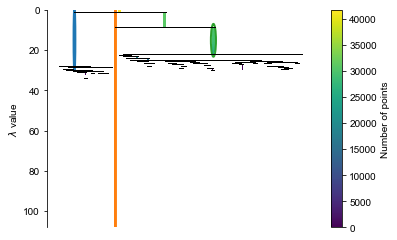

In [12]:
_, _, df_human = UMAP(onehot_input_human, df_human)
_, _, df_human, _ = cluster_HDBSCAN_softclustering(df_human)

===============  Human ===============
Cluster #1: 10595
Cluster #2: 728
Cluster #3: 30408


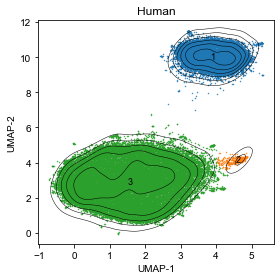

In [13]:
fig, ax = plt.subplots(figsize=(4,4))
draw_one_sample(ax, df_human, title="Human")
plt.tight_layout()
plt.savefig("Human.pdf")
extract_fasta_and_draw_motifs("Human", df_human)

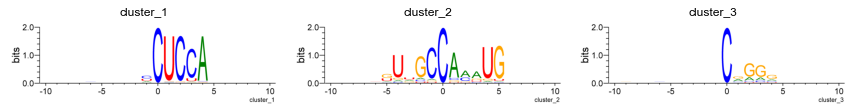

In [14]:
show_logos_cols("./Human/logos_bits_png/", cols=3)

### 1.2 Mouse

In [15]:
# Mouse
onehot_input_mouse = []
df_mouse = pd.read_csv("./Mouse_dev.motif.F10.csv", index_col=[0,1,2], header=[0,1])
for idx, row in df_mouse.iterrows():
    onehot_input_mouse.append(onehot_enc(row))
onehot_input_mouse = np.array(onehot_input_mouse)

UMAP
UMAP time: 70.53734350204468 sec
UMAP RAM: 237.75013256072998 MB

HDBSCAN soft clustering time: 6.596731901168823 sec
HDBSCAN soft clustering RAM: 402.01724910736084 Mb
HDBSCAN cluster number: 3
Cluster
1     2266
2      303
3    42661
Name: Cluster, dtype: int64


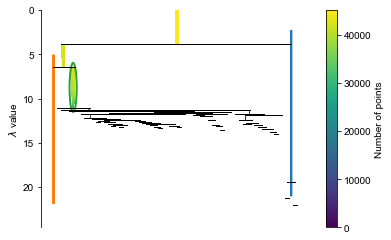

In [16]:
# Mouse
_, _, df_mouse = UMAP(onehot_input_mouse, df_mouse)
_, _, df_mouse, _ = cluster_HDBSCAN_softclustering(df_mouse, min_cluster_size=50, min_samples=50)

===============  Mouse ===============
Cluster #1: 2266
Cluster #2: 303
Cluster #3: 42661


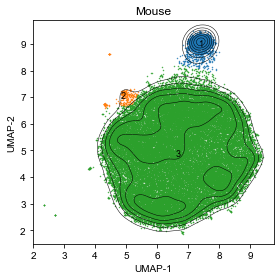

In [17]:
fig, ax = plt.subplots(figsize=(4,4))
draw_one_sample(ax, df_mouse, title="Mouse")
plt.tight_layout()
plt.savefig("Mouse.pdf")
extract_fasta_and_draw_motifs("Mouse", df_mouse)

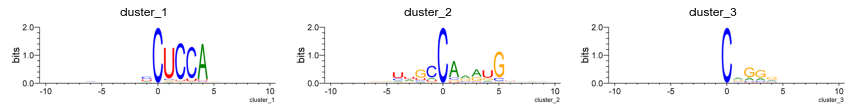

In [18]:
show_logos_cols("./Mouse/logos_bits_png/", cols=3)

### 1.3 Xenopus laevis

In [19]:
# Xenopus laevis
onehot_input_XL = []
df_XL = pd.read_csv("./XL_dev.motif.F10.csv", index_col=[0,1,2], header=[0,1])
for idx, row in df_XL.iterrows():
    onehot_input_XL.append(onehot_enc(row))
onehot_input_XL = np.array(onehot_input_XL)

UMAP
UMAP time: 31.036691427230835 sec
UMAP RAM: 387.4156837463379 MB

HDBSCAN soft clustering time: 2.882619619369507 sec
HDBSCAN soft clustering RAM: 402.75617599487305 Mb
HDBSCAN cluster number: 2
Cluster
1     2506
2    19638
Name: Cluster, dtype: int64


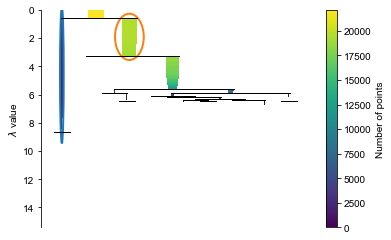

In [20]:
_, _, df_XL = UMAP(onehot_input_XL, df_XL)
_, _, df_XL, _ = cluster_HDBSCAN_softclustering(df_XL, min_cluster_size=100, min_samples=100, cluster_selection_epsilon=0.0)

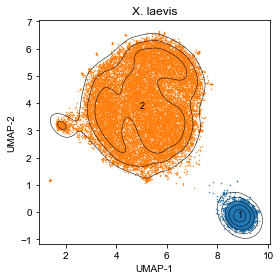

In [21]:
fig, ax = plt.subplots(figsize=(4,4))
draw_one_sample(ax, df_XL, title="X. laevis")
plt.tight_layout()
plt.savefig("XL.eom.pdf")

HDBSCAN soft clustering time: 3.86083722114563 sec
HDBSCAN soft clustering RAM: 369.170334815979 Mb
HDBSCAN cluster number: 32
Cluster
1     2506
3      628
4      135
5      554
6      368
7     1460
8      894
9      567
10     404
11     605
12     951
13     992
14     721
15     506
16     600
17     845
18     563
19     475
20     620
21    1376
22     651
23     817
24     453
25     420
26     378
27     705
28     697
29     440
30     657
31     774
32     382
Name: Cluster, dtype: int64


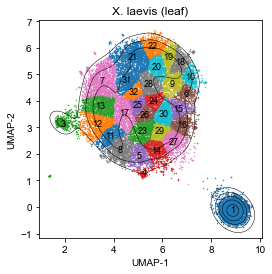

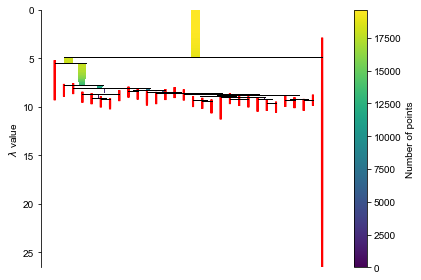

In [22]:
# hard clustering
fig, ax = plt.subplots(figsize=(4,4))
_, _, df_XL2, _ = subcluster_HDBSCAN_softclustering(df_XL, target=2, cluster_selection_method="leaf")
draw_one_sample(ax, df_XL2, title="X. laevis (leaf)")
plt.tight_layout()
plt.savefig("XL.leaf.pdf")

===============  XL ===============
Cluster #1: 2506
Cluster #2: 19010
Cluster #3: 628


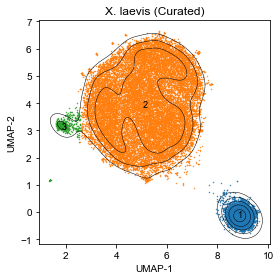

In [23]:
df_XL2.loc[df_XL2["Cluster"]>3, "Cluster"] = 2
df_XL = df_XL2
fig, ax = plt.subplots(figsize=(4,4))
draw_one_sample(ax, df_XL, title="X. laevis (Curated)")
plt.tight_layout()
plt.savefig("XL.pdf")
extract_fasta_and_draw_motifs("XL", df_XL)

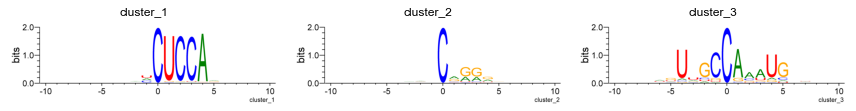

In [24]:
show_logos_cols("./XL/logos_bits_png/", cols=3)

### 1.4 Xenopus tropicalis

In [25]:
# Xenopus tropicalis
onehot_input_XT = []
df_XT = pd.read_csv("./XT_dev.motif.F10.csv", index_col=[0,1,2], header=[0,1])
for idx, row in df_XT.iterrows():
    onehot_input_XT.append(onehot_enc(row))
onehot_input_XT = np.array(onehot_input_XT)

UMAP
UMAP time: 26.41177225112915 sec
UMAP RAM: 255.0694408416748 MB

HDBSCAN soft clustering time: 2.1967201232910156 sec
HDBSCAN soft clustering RAM: 257.8746519088745 Mb
HDBSCAN cluster number: 3
Cluster
1     2734
2      169
3    15620
Name: Cluster, dtype: int64


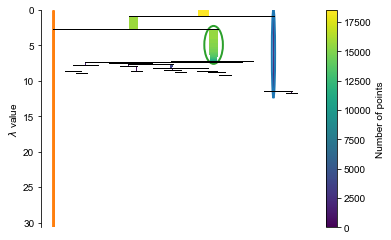

In [26]:
_, _, df_XT = UMAP(onehot_input_XT, df_XT)
_, _, df_XT, _ = cluster_HDBSCAN_softclustering(df_XT, min_cluster_size=50, min_samples=50)

===============  XT ===============
Cluster #1: 2734
Cluster #2: 169
Cluster #3: 15620


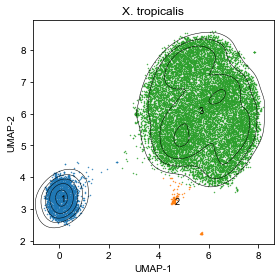

In [27]:
fig, ax = plt.subplots(figsize=(4,4))
draw_one_sample(ax, df_XT, title="X. tropicalis")
plt.tight_layout()
plt.savefig("XT.pdf")
extract_fasta_and_draw_motifs("XT", df_XT)

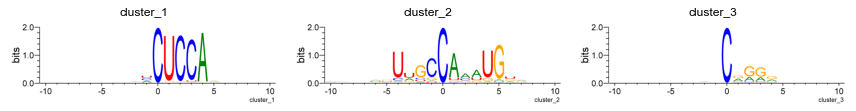

In [28]:
show_logos_cols("./XT/logos_bits_png/", cols=3)

### 1.5 Zebrafish

In [29]:
# Zebrafish
onehot_input_zebrafish = []
df_zebrafish = pd.read_csv("./Zebrafish_dev.motif.F10.csv", index_col=[0,1,2], header=[0,1])
for idx, row in df_zebrafish.iterrows():
    onehot_input_zebrafish.append(onehot_enc(row))
onehot_input_zebrafish = np.array(onehot_input_zebrafish)

UMAP
UMAP time: 26.970539808273315 sec
UMAP RAM: 214.21368217468262 MB

HDBSCAN soft clustering time: 1.1775107383728027 sec
HDBSCAN soft clustering RAM: 216.72607231140137 Mb
HDBSCAN cluster number: 3
Cluster
1     303
2     112
3    8699
Name: Cluster, dtype: int64


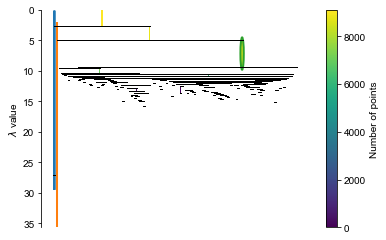

In [30]:
# Zebrafish
_, _, df_zebrafish = UMAP(onehot_input_zebrafish, df_zebrafish)
_, _, df_zebrafish, _ = cluster_HDBSCAN_softclustering(df_zebrafish, min_cluster_size=10, min_samples=10, cluster_selection_epsilon=0.1)

===============  Zebrafish ===============
Cluster #1: 303
Cluster #2: 112
Cluster #3: 8699


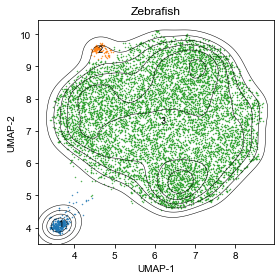

In [31]:
fig, ax = plt.subplots(figsize=(4,4))
draw_one_sample(ax, df_zebrafish, title="Zebrafish")
plt.tight_layout()
plt.savefig("Zebrafish.pdf")
extract_fasta_and_draw_motifs("Zebrafish", df_zebrafish)

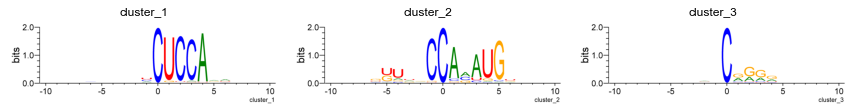

In [32]:
show_logos_cols("./Zebrafish/logos_bits_png/", cols=3)

### 1.6 Fly

In [33]:
# Fly
onehot_input_fly = []
df_fly = pd.read_csv("./Fly_dev.motif.F10.csv", index_col=[0,1,2], header=[0,1])
for idx, row in df_fly.iterrows():
    onehot_input_fly.append(onehot_enc(row))
onehot_input_fly = np.array(onehot_input_fly)

UMAP
UMAP time: 24.904431104660034 sec
UMAP RAM: 186.0784912109375 MB

HDBSCAN soft clustering time: 0.978522777557373 sec
HDBSCAN soft clustering RAM: 181.27210330963135 Mb
HDBSCAN cluster number: 2
Cluster
1     863
2    7539
Name: Cluster, dtype: int64


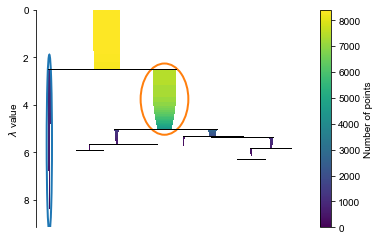

In [34]:
_, _, df_fly = UMAP(onehot_input_fly, df_fly)
_, _, df_fly, _ = cluster_HDBSCAN_softclustering(df_fly, min_cluster_size=50, min_samples=50)

===============  Fly ===============
Cluster #1: 863
Cluster #2: 7539


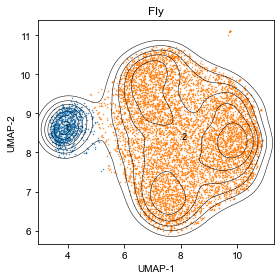

In [35]:
fig, ax = plt.subplots(figsize=(4,4))
draw_one_sample(ax, df_fly, title="Fly")
plt.tight_layout()
plt.savefig("Fly.pdf")
extract_fasta_and_draw_motifs("Fly", df_fly)

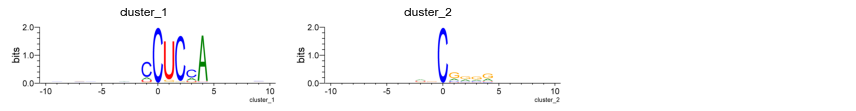

In [36]:
show_logos_cols("./Fly/logos_bits_png/", cols=3, figsize=(9,4))

## 2. Draw species together

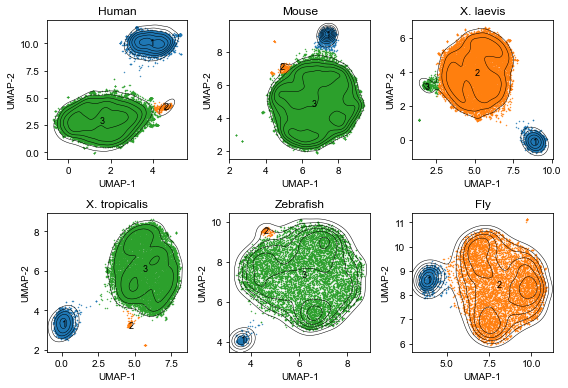

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(8,5.5))

for ax, spec, df in zip(*[axes.reshape(-1), ["Human", "Mouse", "X. laevis", "X. tropicalis", "Zebrafish", "Fly"], [df_human, df_mouse, df_XL, df_XT, df_zebrafish, df_fly]]):
    draw_one_sample(ax, df, title=spec)

plt.tight_layout()
plt.savefig("Specis_clustered_alone.pdf")
plt.savefig("Specis_clustered_alone.png", dpi=300)


## 3. Deep analysis of clusters in different clusters

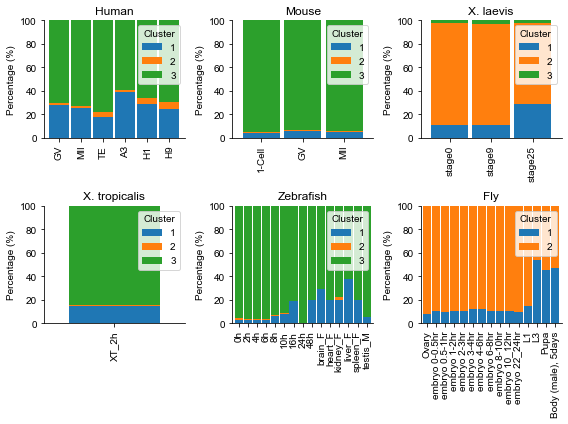

In [38]:
def draw_cluster_trace(ax, df, title=None):
    df_analysis = df.xs("passed", axis=1, level=1).copy()
    df_analysis["Cluster"] = df["Cluster"]

    df_groupby = df_analysis.groupby("Cluster").sum()
    df_groupby.to_csv(title.replace(".","_")+".count.csv")
    
    df_groupby = df_groupby/(df_groupby.sum(axis=0) + 0.) * 100.

    df_groupby = df_groupby.T
    df_groupby.plot(kind="bar", stacked=True, ax=ax, width=0.9)
    ax.set_ylabel("Percentage (%)")
    ax.set_ylim(0, 100)
    sns.despine()
    ax.set_title(title)
    
    df_groupby.to_csv(title.replace(".","_")+".percent.csv")
    
fig, axes = plt.subplots(2, 3, figsize=(8,6))
draw_cluster_trace(axes[0][0], df_human, "Human")
draw_cluster_trace(axes[0][1], df_mouse, "Mouse")
draw_cluster_trace(axes[0][2], df_XL, "X. laevis")
draw_cluster_trace(axes[1][0], df_XT, "X. tropicalis")
draw_cluster_trace(axes[1][1], df_zebrafish, "Zebrafish")
draw_cluster_trace(axes[1][2], df_fly, "Fly")
plt.tight_layout()
plt.savefig("Clusters_percentage.pdf")

## 4. Mix species analysis

To comparatively analyze the pattern of m5C in different species, we can merge the tables and plot them together.

This step will analyze 14,5144 sites together, it will take ~5 min to finish it. It will be much faster working with cuML.

In [39]:
def merge_tables(dfs, names):
    temp = []
    for df, name in zip(*[dfs, names]):
        subdf = df.copy()
        subdf = subdf[[("INFO", "motif_F10")]].copy()
        subdf["Cluster"] = df["Cluster"]
        subdf.columns = [("INFO", "motif_F10"), name]
        temp.append(subdf)
    df_mix = pd.concat(temp, axis=0)
    onehot_input_mix = []
    for idx, row in df_mix.iterrows():
        onehot_input_mix.append(onehot_enc(row))
    onehot_input_mix = np.array(onehot_input_mix)
    return df_mix, onehot_input_mix
        
df_mix,onehot_input_mix = merge_tables([df_human, df_mouse, df_XL, df_XT, df_zebrafish, df_fly], ["Human", "Mouse", "X. laevis", "X. tropicalis", "Zebrafish", "Fly"])
print(df_mix.shape)

(145144, 7)


In [40]:
_, _, df_mix = UMAP(onehot_input_mix, df_mix, verbose=True)

UMAP
UMAP(init='random', min_dist=0.01, n_neighbors=20, random_state=42, verbose=True)
Sat Feb 12 16:35:42 2022 Construct fuzzy simplicial set
Sat Feb 12 16:35:42 2022 Finding Nearest Neighbors
Sat Feb 12 16:35:42 2022 Building RP forest with 24 trees
Sat Feb 12 16:35:59 2022 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	Stopping threshold met -- exiting after 7 iterations
Sat Feb 12 16:36:37 2022 Finished Nearest Neighbor Search
Sat Feb 12 16:36:39 2022 Construct embedding



Sat Feb 12 16:39:37 2022 Finished embedding
UMAP time: 235.41749119758606 sec
UMAP RAM: 697.3179693222046 MB



HDBSCAN soft clustering time: 42.72393083572388 sec
HDBSCAN soft clustering RAM: 691.9628658294678 Mb
HDBSCAN cluster number: 3
Cluster
1     19837
2      1825
3    123482
Name: Cluster, dtype: int64


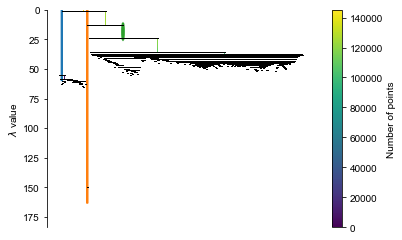

In [41]:
_, _, df_mix, _ = cluster_HDBSCAN_softclustering(df_mix, min_cluster_size=100, min_samples=10)

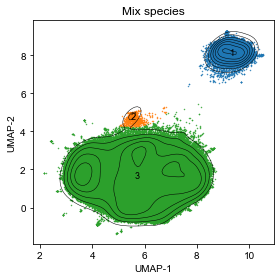

In [42]:
fig, ax = plt.subplots(figsize=(4,4))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_mix, title="Mix species")
plt.tight_layout()
plt.savefig("Mixed_clusters.png", dpi=300)

In [43]:
extract_fasta_and_draw_motifs("Mix", df_mix)

===============  Mix ===============
Cluster #1: 19837
Cluster #2: 1825
Cluster #3: 123482


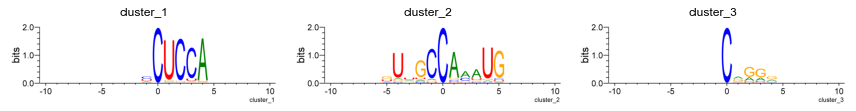

In [44]:
show_logos_cols("./Mix/logos_bits_png/", cols=3)

### 4.1 Label all clusters within each species

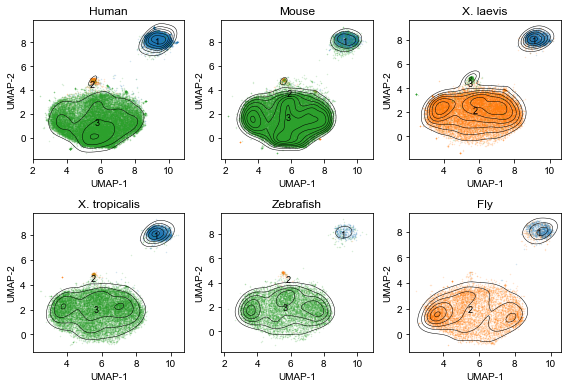

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(8,5.5))

for ax, i in zip(*[axes.reshape(-1), ["Human", "Mouse", "X. laevis", "X. tropicalis", "Zebrafish", "Fly"]]):
    draw_one_sample_by_species(ax, df_mix, target=i, title=i, save_contour_diameter=5.8)
plt.tight_layout()
plt.savefig("Specis_clustered_together.pdf")
plt.savefig("Specis_clustered_together.png", dpi=300)

### 4.2 Analyzing the difference between vertebrates and invertebrates

Obviously, we found that the methylation patterns in Fly is a bit different from that in vertebrates:

(1) Ther cluster \#1 in fly (NSUN6-dependent) have some mixture with cluster \#2, which might result from our reported preference of fly NSUN6 at -1 and +3 positions.

(2) The cluster \#2 in fly (NSUN2-dependent) seems to split into two groups (left and right), while vertebrate NSUN2-dependent clusters seem to in three clusters;

To verfiy that, we can extract the features.

### 4.2.1 Split fly cluster \#2

HDBSCAN soft clustering time: 0.8550381660461426 sec
HDBSCAN soft clustering RAM: 676.590576171875 Mb
HDBSCAN cluster number: 3
Fly
1.0     863
3.0     169
4.0    1178
5.0    1313
6.0     861
7.0    1480
8.0     735
9.0    1803
Name: Fly, dtype: int64


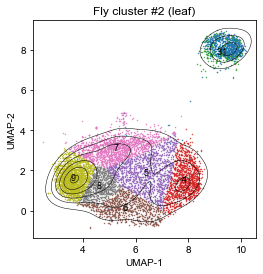

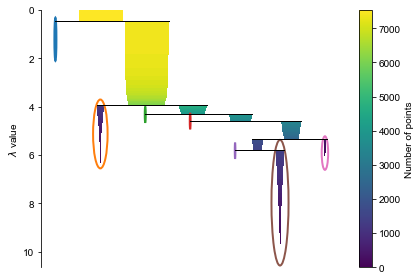

In [46]:
df_mix_fly = df_mix[df_mix["Fly"]>=-1].copy()

fig, ax = plt.subplots(figsize=(4,4))
_, _, df_mix_fly, _ = subcluster_HDBSCAN_softclustering(df_mix_fly, target=2, cluster_col="Fly", cluster_selection_method="leaf")
_ = draw_one_sample(ax, df_mix_fly, title="Fly cluster #2 (leaf)", cluster_col="Fly")
plt.tight_layout()
plt.savefig("Fly.cluster2_recluster.png", dpi=300)

===============  Fly_mix_subclusters ===============
Cluster #1: 863
Cluster #3: 169
Cluster #4: 1178
Cluster #5: 2174
Cluster #6: 4018


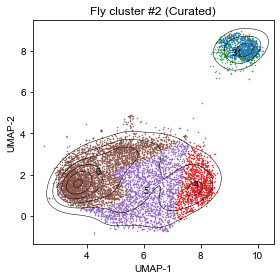

In [47]:
# We manually merge cluster 7,8,9 into 6 cluster 4 into 4; cluster 5, 6 into 5; cluster 3 into "3
df_mix_fly.loc[df_mix_fly["Fly"].isin([3]), "Fly"] = 3
df_mix_fly.loc[df_mix_fly["Fly"].isin([4]), "Fly"] = 4
df_mix_fly.loc[df_mix_fly["Fly"].isin([5, 6]), "Fly"] = 5
df_mix_fly.loc[df_mix_fly["Fly"].isin([7,8,9]), "Fly"] = 6
df_mix_fly["Fly"] = df_mix_fly["Fly"].astype(int)

fig, ax = plt.subplots(figsize=(4,4))
_ = draw_one_sample(ax, df_mix_fly, title="Fly cluster #2 (Curated)", cluster_col="Fly")
extract_fasta_and_draw_motifs("Fly_mix_subclusters", df_mix_fly, cluster_col="Fly")
plt.tight_layout()
plt.savefig("Fly.curated.png", dpi=300)
plt.savefig("Fly.curated.pdf", dpi=300)

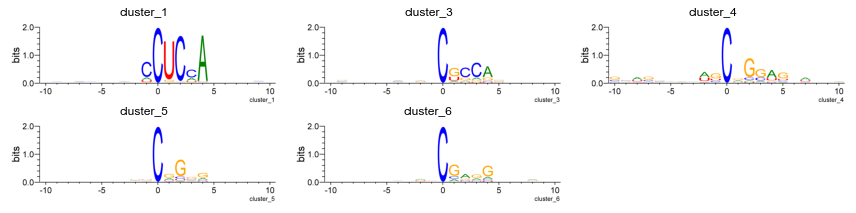

In [48]:
show_logos_cols("./Fly_mix_subclusters/logos_bits_png/", cols=3)

Based the motifs, we now know that cluster #4 is CNGGAG; cluster #5 is C[A/G]GN[A/G]; cluster #6 is CG[A/G][A/G]G. And cluster #3 is false assignment.

## Finally, save all tables to disk

In [49]:
df_human.to_csv("Human_clustered.csv")
df_mouse.to_csv("Mouse_clustered.csv")
df_XL.to_csv("XL_clustered.csv")
df_XT.to_csv("XT_clustered.csv")
df_zebrafish.to_csv("Zebrafish_clustered.csv")
df_fly.to_csv("Fly_clustered.csv")
df_mix.to_csv("Mix_clustered.csv")